<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Modeling_C660.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
import torch
from google.colab import drive
drive.mount('/content/drive')
!pip install autorch > log.txt
torch.manual_seed(11)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = '/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/'

t651_df = pd.read_csv(root+'t651_train.csv',index_col=0).dropna(axis=0)
idx = t651_df.index

c620_df = pd.read_csv(root+'c620_train.csv',index_col=0).loc[idx]
c620_mb = pd.read_csv(root+'c620_mbcheck.csv',index_col=0).loc[idx]

c660_df = pd.read_csv(root+'c660_train.csv',index_col=0).loc[idx]
c660_mb = pd.read_csv(root+'c660_mbcheck.csv',index_col=0).loc[idx]

c670_df = pd.read_csv(root+'c670_train.csv',index_col=0).loc[idx]
c670_mb = pd.read_csv(root+'c670_mbcheck.csv',index_col=0).loc[idx]

In [3]:
root = '/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/'
c620_col = joblib.load(root+'c620_col_names.pkl')
c660_col = joblib.load(root+'c660_col_names.pkl')
c670_col = joblib.load(root+'c670_col_names.pkl')
t651_col = joblib.load(root+'t651_col_names.pkl')

In [4]:
t651_mf = t651_df[t651_col['MFR']]
c620_mf = c620_mb.loc[:,['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Mass Flow Rate_ton/hr']]
total = t651_mf.values + c620_mf.values
t651_mf = t651_mf/total
c620_mf = c620_mf/total
t651_x41 = t651_df[t651_col['x41']]
c620_w3 = c620_df[c620_col['sidedraw_x']]
c660_feed_pred = c620_w3.values*c620_mf.values + t651_x41.values*t651_mf.values
c660_feed_pred = pd.DataFrame(c660_feed_pred,index=idx,columns=c660_col['x41'])
c660_feed_pred.head(3)

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
001-001,0.0,0.000175,0.011354,0.021681,0.014908,0.019511,0.030082,66.278216,0.02099,0.034398,0.0,0.014600,27.873568,0.028611,0.024798,0.020281,3.132133,0.632336,1.318028,0.365566,0.044484,1.951733e-08,0.098763,3.399222e-09,0.001142,0.001141,0.00223,0.00057,0.00057,0.00788,3.896395e-09,1.684247e-10,0.001555,0.000415,6.044997e-10,0.0,6.479632e-12,3.103609e-13,3.014521e-16,0.0,0.0
001-002,0.0,0.000175,0.011353,0.021678,0.014906,0.019510,0.030081,66.278232,0.02099,0.034399,0.0,0.014601,27.873554,0.028611,0.024798,0.020281,3.132134,0.632336,1.318029,0.365566,0.044484,1.951592e-08,0.098764,3.398967e-09,0.001142,0.001141,0.00223,0.00057,0.00057,0.00788,3.896085e-09,1.684114e-10,0.001555,0.000415,6.044514e-10,0.0,6.479096e-12,3.103352e-13,3.014266e-16,0.0,0.0
001-003,0.0,0.000175,0.011354,0.021680,0.014907,0.019510,0.030082,66.278226,0.02099,0.0

In [5]:
c660_feed = c660_df[c660_col['x41']]
c660_feed.head(3)

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
001-001,0.0,0.000175,0.011354,0.021681,0.014908,0.019511,0.030082,66.278221,0.02099,0.034398,0.0,0.014600,27.873569,0.028611,0.024798,0.020281,3.132133,0.632336,1.318029,0.365566,0.044484,1.951733e-08,0.098763,3.399222e-09,0.001142,0.001141,0.00223,0.00057,0.00057,0.00788,3.896395e-09,1.684246e-10,0.001555,0.000415,6.044996e-10,0.0,6.479631e-12,3.103609e-13,3.014521e-16,0.0,0.0
001-002,0.0,0.000175,0.011353,0.021678,0.014906,0.019510,0.030081,66.278244,0.02099,0.034399,0.0,0.014601,27.873554,0.028611,0.024798,0.020281,3.132135,0.632336,1.318029,0.365566,0.044484,1.951592e-08,0.098764,3.398968e-09,0.001142,0.001141,0.00223,0.00057,0.00057,0.00788,3.896086e-09,1.684114e-10,0.001555,0.000415,6.044514e-10,0.0,6.479096e-12,3.103352e-13,3.014266e-16,0.0,0.0
001-003,0.0,0.000175,0.011354,0.021680,0.014907,0.019510,0.030082,66.278236,0.02099,0.0

In [6]:
np.allclose(c660_feed.values,c660_feed_pred.values)

True

In [7]:
# replace
c = c660_col
c660_df.loc[:,c['x41']] = c660_feed_pred.values

In [8]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
y_col = sp_col + op_col
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]
for idx in n_idx:
  assert np.allclose(c660_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)

In [9]:
c660_df.loc[['001-002', '001-005', '001-008', '001-011', '001-014'],
            x_col+y_col].to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/Data_format_example/c660_data.xlsx')

  0%|          | 1/300 [00:00<03:07,  1.59it/s]

epoch:0 train_loss:0.0081 valid_loss:0.0020


 17%|█▋        | 51/300 [00:41<03:27,  1.20it/s]

epoch:50 train_loss:0.0009 valid_loss:0.0009


 34%|███▎      | 101/300 [01:24<02:52,  1.15it/s]

epoch:100 train_loss:0.0008 valid_loss:0.0008


 50%|█████     | 151/300 [02:08<02:14,  1.11it/s]

epoch:150 train_loss:0.0008 valid_loss:0.0008


 67%|██████▋   | 201/300 [02:56<01:40,  1.01s/it]

epoch:200 train_loss:0.0007 valid_loss:0.0008


 84%|████████▎ | 251/300 [03:49<00:51,  1.06s/it]

epoch:250 train_loss:0.0007 valid_loss:0.0009


100%|██████████| 300/300 [04:43<00:00,  1.06it/s]


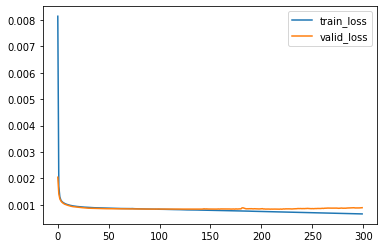

In [10]:
from autorch.utils import PartBulider
c660 = PartBulider(c660_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c660.train()

In [11]:
c660.test(e=0.02)

,R2,MSE,MAPE
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Hydrogen_Fraction,0,1.67676e-07,0.0324528
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Methane_Fraction,0.982379,0.000338746,2.33881
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Ethane_Fraction,0.997473,0.000174115,2.34409
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Propane_Fraction,0.999071,8.61864e-05,2.94123
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_n-Butane_Fraction,0.998754,8.77268e-05,3.32357
...,...,...,...
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997055,0.0191237,0.839868
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.997644,0.016457,0.806689
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.997323,0.000117802,0.0094611
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.997221,0.00220621,0.0398916


In [12]:
from autorch.function import sp2wt

x_test = c660.data['X_test']
x41 = x_test[c['x41']].values
sp = c660.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [13]:
wt_real = c660_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [14]:
c660.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.963739,5.404843e-03,2.250007
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.996168,1.447708e-01,1.076797
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.973948,1.258918e-01,1.080223
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997251,3.489564e-02,2.150301
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,6.534207e-30,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,8.652470e-36,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


# 確認 約束條件

In [15]:
naidx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29]
(wt_pred.filter(regex='Sidedraw').iloc[:,naidx].sum(axis=1)*10000).to_frame().head()

,0
062-061,914.985535
031-005,948.412842
087-060,953.702698
013-072,917.091309
014-026,920.494080


In [16]:
x_test[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']].head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
062-061,919.947571
031-005,950.005859
087-060,949.996521
013-072,920.005493
014-026,920.000732


# 針對約束條件做後處理

In [17]:
def c660_wt_post_processing(wt_pred,na_total):
  def normalize(x):
    return x / x.sum(axis=1).reshape(-1,1)
  na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
  other_idx = list(set([*range(41)])-set(na_idx))
  na_total = (na_total/10000).reshape(-1,1)
  other_total = 100 - na_total
  wt_pred.iloc[:,41*2:41*3].iloc[:,na_idx] = normalize(wt_pred.iloc[:,41*2:41*3].iloc[:,na_idx].values)*na_total
  wt_pred.iloc[:,41*2:41*3].iloc[:,other_idx] = normalize(wt_pred.iloc[:,41*2:41*3].iloc[:,other_idx].values)*other_total
  return wt_pred

In [18]:
wt_pred = c660_wt_post_processing(wt_pred,x_test['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'].values)

# 再次確認約束條件

In [19]:
naidx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29]
(wt_pred.filter(regex='Sidedraw').iloc[:,naidx].sum(axis=1)*10000).to_frame().head()

,0
062-061,919.947449
031-005,950.005859
087-060,949.996582
013-072,920.005493
014-026,920.000732


In [20]:
x_test[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']].head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
062-061,919.947571
031-005,950.005859
087-060,949.996521
013-072,920.005493
014-026,920.000732


# 再次評估準確度

In [21]:
c660.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.963739,5.404843e-03,2.250007
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.996168,1.447708e-01,1.076797
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.973948,1.258918e-01,1.080223
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997251,3.489564e-02,2.150301
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,6.534207e-30,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,8.652470e-36,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [22]:
c660.shrink()

In [23]:
joblib.dump(c660,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl']